In [1]:
import sys 
sys.path.append('../src/')

In [2]:
import numpy as np 
import pennylane as qml 
import circuits 
from jax import vmap, jit, numpy as jnp, value_and_grad 
import optax

class qcnn:
    def __init__(self, L, PARAMS = [], lr = 1e-2):
        """
        This class requires:
            STATES: an array of L wavefunctions (L, 2**n_qubits)
            PARAMS: an array of the parameters of the ANNNI model relative to the STATES wavefunction
                    PARAMS = (L, 2)
                                 |
                                h and kappa
        """ 

        # number of initial qubits of the QCNN: 
        self.n_qubits  = L
        self.n_outputs = 2

        self.PARAMS = PARAMS 

        def qcnn_circuit(state, params):
            # Wires that are not measured (through pooling)
            active_wires = np.arange(self.n_qubits)

            qml.QubitStateVector(state, wires=range(self.n_qubits))

            # Visual Separation State||QCNN
            qml.Barrier()
            qml.Barrier()

            # Index of the parameter vector
            index = 0

            # Iterate Convolution+Pooling until we only have a single wires
            index = circuits.wall_gate(active_wires, qml.RY, params, index)
            circuits.wall_cgate_serial(active_wires, qml.CNOT)
            while len(active_wires) > self.n_outputs:  # Repeat until the number of active wires
                # (non measured) is equal to n_outputs
                # Convolute
                index = circuits.convolution(active_wires, params, index)
                # Measure wires and apply rotations based on the measurement
                index, active_wires = circuits.pooling(active_wires, qml.RX, params, index)

                qml.Barrier()

            circuits.wall_cgate_serial(active_wires, qml.CNOT)
            index = circuits.wall_gate(active_wires, qml.RY, params, index)

            # Return the number of parameters
            return index + 1, active_wires

        self.device = qml.device('default.qubit.jax', wires=self.n_qubits)
        
        self.circuit_fun  = qcnn_circuit

        # Create a dummy state to compute the number of parameters needed.
        dummystate = np.zeros(2**self.n_qubits) 
        dummystate[0] = 1  # State needs to be normal
        self.n_params, self.final_active_wires = self.circuit_fun(dummystate, np.zeros(10000)) 
        if len(self.PARAMS) == 0: # if the parameters are the default ones...
            self.PARAMS = np.random.normal(loc = 0, scale = 1, size = (self.n_params, )) # mean  = 0
                                                                                         # stdev = 1 roghly each point is
                                                                                         # in [-pi, +pi]

        def circuit(x, p):
            self.circuit_fun(x, p)
            return qml.probs([int(k) for k in self.final_active_wires])

        self.q_circuit    = qml.QNode(circuit, self.device)
        self.v_q_circuit  = vmap(self.q_circuit, (0, None))
        self.jv_q_circuit = jit(self.v_q_circuit)

        def loss_fun(x, params, y, qcirc):
            out = qcirc(x, params)
            pred = 0.5 + jnp.tensordot(out, jnp.array([-0.5, +0.5]), axes=0)  # Mapping output expectation value to probability vector

            logprob = jnp.log(pred)

            return -logprob[y]
        
        self.get_loss    = lambda x, p, y: loss_fun(x, p, y, self.q_circuit)
        self.v_get_loss  = vmap(self.get_loss, (0, None, 0))
        self.jv_get_loss = jit(self.v_get_loss)

        def mean_loss(p, X, Y):
            # self.jv_get_loss outputs the single loss X[i]<->Y[i]
            # we need to reduce the matrix to a single scalar value
            return jnp.mean(self.jv_get_loss(X, p, Y))

        def optimizer_update(opt, opt_state, X, p, Y):
            loss, grads = value_and_grad(mean_loss)(p, X, Y)
            updates, opt_state = opt.update(grads, opt_state)
            p = optax.apply_updates(p, updates)
            return p, opt_state, loss, 0
        
        # Update the optimizer
        self.optimizer = optax.adam(learning_rate=lr)
        self.update = jit(lambda opt_state, X, p, Y: optimizer_update(self.optimizer, opt_state, X, p, Y))

    def __repr__(self):
        # Create a dummy state to compute the number of parameters needed.
        dummystate = np.zeros(2**self.n_qubits) 
        dummystate[0] = 1  # State needs to be normal

        reprstr  = f'Number of qubits : {self.n_qubits}\n'
        reprstr += f'Number of params : {self.n_params}\n\n'
        reprstr += 'Circuit:\n'
        reprstr += qml.draw(self.q_circuit)(dummystate, np.arange(self.n_params))
        return reprstr

In [14]:
import numpy as np
import pennylane as qml
from jax import jit
import jax.numpy as jnp
from opt_einsum import contract
import ANNNIgen
import mpsgen
import os
from typing import Tuple, List, Callable
import tqdm

import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap

class state:
    def __init__(self, L : int, h : float, k : float, shapes : np.ndarray, tensors : np.ndarray, towave_func : Callable):
        self.L, self.h, self.k = L, h, k
        self.shapes = shapes.astype(int)
        # This needs some explanation:
        # 1. Start from `tensors`, it is just a list of value that have to be grouped in smaller
        #    tensors according to the shapes list, that defines the list of the smaller tensors
        # 2. Compute self.splits, it tells the indexes for splitting the full vector into
        #    the smaller tensors
        #    EX:
        #        [a,b,c,d,e,f,g,h] : full vector
        #         0 1 2 3 4 5 6 7    index
        #        [2,6]             : self.splits
        #        self.splits tells you how to break the full vector
        #        [a,b] [c,d,e,f] [g,h] : split vectors
        self.splits = np.cumsum(np.prod(shapes, axis=1)).astype(int)
        # 3. Compute the MPS:
        #     3.1: Group the elements in split vectors (not split tensors yet)
        #          np.array_split(tensors, self.splits)[:-1] 
        #          flat_tn = np.array_split(tensors, self.splits)[:-1] split vectors, List of L vectors
        #                    NOTE: np.array_split(tensors, self.splits)[-1] is empty
        #     3.2: Reshape each of the L vector into tensor with the shape declared in self.shape
        # 3.1 and 3.2 done together to avoid garbage collector shenanigans
        self.MPS = [site.reshape(self.shapes[i]) for i, site in enumerate(np.array_split(tensors, self.splits)[:-1])]

        self.towave = lambda : towave_func(self.MPS)
        
class mps:
    def __init__(self, folder : str = '../tensor_data/', gpu : bool = False):
        ###########################
        #      CHECK FOLDER       #
        ###########################
        self.path = folder

        self.col3 = [[0.456, 0.902, 0.635, 1],
                     [0.400, 0.694, 0.800, 1],
                     [0.922, 0.439, 0.439, 1]]

        self.col4 = [[0.456, 0.902, 0.635, 1],
                     [0.400, 0.694, 0.800, 1],
                     [1.000, 0.514, 0.439, 1],
                     [0.643, 0.012, 0.435, 1]]
        # Check if folder exists
        try: 
            files_all        = np.array(os.listdir(folder))
            self.files_shape = files_all[np.char.startswith(files_all,'shapes_sites')]
            self.files_tens  = files_all[np.char.startswith(files_all,'tensor_sites')]
        except:
            raise TypeError(f'Folder {folder} not found')
        
        def get_info(file_string : str) -> Tuple[int, float, float, int, int]:
            """
            1. Split big string into array of string
            'shapes_sites_ANNNI_L_{L}_h_{h}_kappa_{k}'
                into
            ['shapes', 'sites', 'ANNNI', 'L', '{L}','h', '{h}', 'kappa', '{k}']
              0         1        2        3    4^    5    6^     7        8^
            2. Take the element 4, 6 and 8 
            """
            split_str = file_string.split('_')

            # return respectively:
            # L, h, k, precision on h, precision on k
            return int(split_str[4]), float(split_str[6]), float(split_str[8]), len(split_str[6].split('.')[1]), len(split_str[8].split('.')[1])
        
        # Check if files are okay
        Ls_shape, hs_shape, ks_shape, hs_shape_prec, ks_shape_prec = [], [], [], [], []
        Ls_tens,  hs_tens,  ks_tens,  hs_tens_prec,  ks_tens_prec  = [], [], [], [], []
        for file in self.files_shape:
            L, h, k, hprec, kprec = get_info(file)
            Ls_shape.append(L)
            hs_shape.append(h)
            ks_shape.append(k)
            hs_shape_prec.append(hprec)
            ks_shape_prec.append(kprec)
        for file in self.files_tens:
            L, h, k, hprec, kprec = get_info(file)
            Ls_tens.append(L)
            hs_tens.append(h)
            ks_tens.append(k)
            hs_tens_prec.append(hprec)
            ks_tens_prec.append(kprec)

        # Check on L
        if len(np.unique(Ls_shape)) > 1 or len(np.unique(Ls_tens)) > 1:
            raise ValueError(f'L has multiple values')
        elif Ls_shape[0] != Ls_tens[0]:
            raise ValueError(f'L has inconsistent values')
        # otherwise L is okay:
        self.L = Ls_shape[0]

        # Check on h and k
        #  None for now
        self.hs = np.sort(np.unique(hs_shape))
        self.ks = np.sort(np.unique(ks_shape))

        # Check on precisions
        if len(np.unique(hs_shape_prec + hs_tens_prec)) > 1 or len(np.unique(ks_shape_prec + ks_tens_prec)) > 1: 
            raise ValueError('Inconsistent precisions in files')
        self.h_prec = hs_shape_prec[0]
        self.k_prec = ks_shape_prec[0]

        # Format of the file names:
        # shape_file  : shape_sites_ANNNI_L_{N}_h_{h}_kappa_{k}
        self.shape_str  = lambda h, k : folder+f'shapes_sites_ANNNI_L_{self.L}_h_{h:.{self.h_prec}f}_kappa_{k:.{self.k_prec}f}'
        # tensor_file : shape_sites_ANNNI_L_{N}_h_{h}_kappa_{k}
        self.tensor_str = lambda h, k : folder+f'tensor_sites_ANNNI_L_{self.L}_h_{h:.{self.h_prec}f}_kappa_{k:.{self.k_prec}f}'

        ###########################
        #      LOAD ALL MPS       #
        ###########################
        self.mpstowavefunc_subscript = mpsgen.get_subscript(self.L)
        if gpu:
            self.get_psi = lambda TT: contract(self.mpstowavefunc_subscript, *TT, backend='jax').flatten()
        else:
            self.get_psi = lambda TT: contract(self.mpstowavefunc_subscript, *TT).flatten() # type: ignore

        self.MPS     = []
        self.Hparams = []

        # We save the labels as integers (0,1,2,3) and as 2-qubits states
        # for an easier implementaion with the QCNN
        self.labels3, self.labels3_state = [], []
        self.labels4, self.labels4_state = [], []
        def labeltostate(label):
            if   label == 0: 
                return [0,0,0,1]
            elif label == 1: 
                return [0,0,1,0]
            elif label == 2:
                return [0,1,0,0]
            elif label == 3: 
                return [1,0,0,0]
            else: 
                raise ValueError("Invalid label")
        # Well load all the states using h as inner variable loop
        # With this, I am assuming the variables h and k are disposed
        # into a grid, uniformly spaced
        # TODO: Read directly from the folder
        for k in self.ks:
            for h in self.hs:
                    self.Hparams.append([h,k])
                    label3,       label4       = ANNNIgen.get_labels(h,-k)
                    label3_state, label4_state = labeltostate(label3), labeltostate(label4)
                    self.labels3.append(label3)
                    self.labels4.append(label4)
                    self.labels3_state.append(label3_state)
                    self.labels4_state.append(label4_state)
                    shapes  = np.loadtxt(self.shape_str(h,k)).astype(int)
                    tensors = np.loadtxt(self.tensor_str(h,k))
                    self.MPS.append(state(self.L, h, k, shapes, tensors, self.get_psi))

        self.Hparams = np.array(self.Hparams) # type: ignore
        self.labels3,       self.labels4       = np.array(self.labels3),       np.array(self.labels4)
        self.labels3_state, self.labels4_state = np.array(self.labels3_state), np.array(self.labels3_state)
        self.MPS = np.array(self.MPS)

        # Additionally, create a mask for the points in the axes (analitical)
        self.mask_analitical = np.logical_or(self.Hparams[:,0] == 0, self.Hparams[:,1] == 0) # type: ignore
        self.mask_analitical_ferro = np.logical_or(np.logical_and(self.Hparams[:,0] < .5, self.Hparams[:,1] == 0),
                                                   np.logical_and(self.Hparams[:,0] == 0, self.Hparams[:,1] <= 1))
        self.mask_analitical_para  = np.logical_and(self.Hparams[:,0] >= .5, self.Hparams[:,1] == 0)
        self.mask_analitical_anti  = np.logical_and(self.Hparams[:,0] ==  0, self.Hparams[:,1] >  1)
        
        self.qcnn = qcnn(self.L)

    def train(self, epochs, PSI, Y, opt_state):
        params = self.qcnn.PARAMS

        progress = tqdm.tqdm(range(epochs), position=0, leave=True)
        for epoch in range(epochs):
            params, opt_state, train_loss, accuracy = self.qcnn.update(opt_state, PSI, params, Y)

            # Update progress bar
            progress.update(1)
            
        self.qcnn.PARAMS = params 
        return opt_state
    
    def train3(self, epochs = 100, train_indices = [], batch_size = 0):
        if len(train_indices) == 0:
            # Set the analytical points as training inputs
            train_indices = np.arange(len(self.MPS)).astype(int)[self.mask_analitical]

        opt_state = self.qcnn.optimizer.init(self.qcnn.PARAMS)
        if batch_size == 0:
            STATES = [mpsclass.towave() for mpsclass in self.MPS[train_indices]]
            STATES = jnp.array(STATES)
            YSTATES      = self.labels3_state[train_indices]
            Y      = self.labels3[train_indices]
            print(train_indices)
            print(np.unique(Y))
            print(np.shape(STATES), np.shape(Y))
            self.train(epochs, STATES, YSTATES, opt_state)

    def predict(self, batch_size = 0, plot = False):
        if batch_size == 0:
            STATES = [mpsclass.towave() for mpsclass in self.MPS]
            STATES = jnp.array(STATES)
            
            PREDICTIONS = self.qcnn.jv_q_circuit(STATES, self.qcnn.PARAMS)

        PREDICTIONS = np.argmax(PREDICTIONS, axis=1)
    
        if plot: 
            ANNNIgen.plot_layout(self, False, True, True, 'prediction', figure_already_defined = False)
            plt.imshow(np.rot90(np.reshape(PREDICTIONS, (len(self.hs), len(self.ks)))))

    def plot_labels(self):
        cm3 = ListedColormap(self.col3, name='color3')
        cm4 = ListedColormap(self.col4, name='color4')
        fig = plt.figure(figsize=(15,12))
        ax1 = fig.add_subplot(1,2,1)
        ANNNIgen.plot_layout(self, True, True, True, '3 Phases', figure_already_defined = True)
        ax1.imshow(np.rot90(np.reshape(self.labels3, (len(self.hs), len(self.ks)))), cmap=cm3)
        ax2 = fig.add_subplot(1,2,2)
        ANNNIgen.plot_layout(self, True, True, True, '3 Phases + floating phase', figure_already_defined = True)
        ax2.imshow(np.rot90(np.reshape(self.labels4, (len(self.hs), len(self.ks)))), cmap=cm4)
        

In [15]:
TT = mps(gpu=True)

In [17]:
TT.labels3[420]

2

In [16]:
TT.train3()

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  42  63  84 105 126 147 168 189 210 231 252 273 294 315
 336 357 378 399 420]
[0 1]
(41, 4096) (41, 4)


  0%|          | 0/100 [00:00<?, ?it/s]/home/saverio/.local/lib/python3.10/site-packages/autoray/autoray.py:981: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return x.astype(dtype, **kwargs)
  0%|          | 0/100 [00:58<?, ?it/s]


KeyboardInterrupt: 

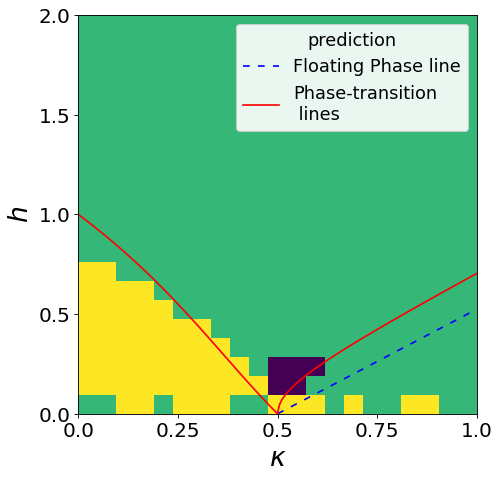

In [10]:
TT.predict(plot=True)

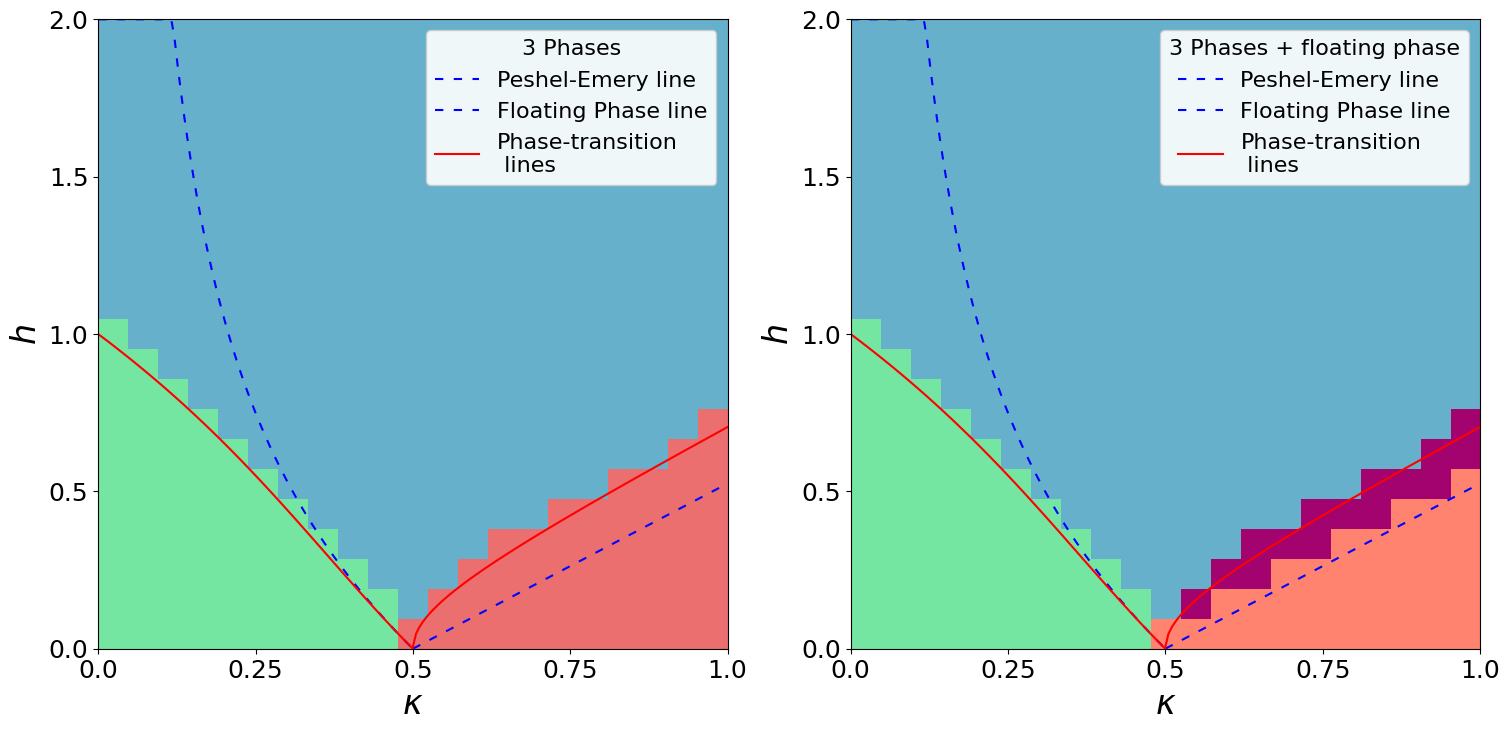

In [5]:
TT.plot_labels()

/home/saverio/Desktop/ANNNI2/.venv/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


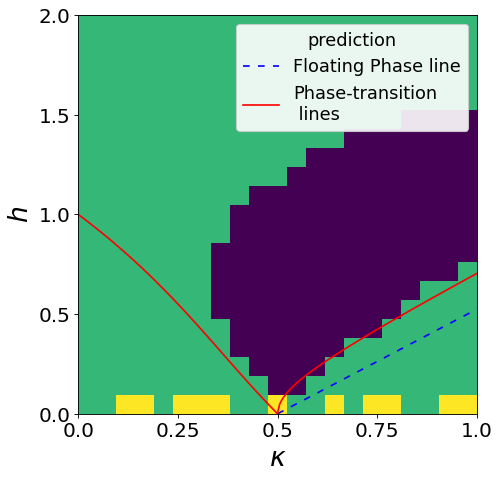

In [6]:
TT.predict(plot=True)